In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# -----------------------------
# 1. Load and preprocess dataset
# -----------------------------
data = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data['Time'] = StandardScaler().fit_transform(data['Time'].values.reshape(-1, 1))
data = data.drop(['Time'], axis=1)

dataset = data.to_numpy().astype(np.float32)

X = dataset[:, :-1]
y = dataset[:, -1]

In [4]:
# Split entire dataset into train and test
data_train, data_test, label_train, label_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
# -----------------------------
# 3. Define the Autoencoder Model
# -----------------------------
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder: 30 -> 23 -> 19 -> 17 -> 8
        self.encoder = nn.Sequential(
            nn.Linear(29, 23),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(23, 19),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(19, 17),
            nn.Tanh(),
            nn.Linear(17, 8)
        )
        # Decoder: 8 -> 17 -> 19 -> 23 -> 30 with Sigmoid at the end
        # (Sigmoid is optional if you are using MSELoss and inputs are not strictly [0,1])
        self.decoder = nn.Sequential(
            nn.Linear(8, 17),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(17, 19),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(19, 23),
            nn.LeakyReLU(0.2),
            nn.Linear(23, 29)
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

(284, 29)
Epoch 0, Train Loss: 25.3605, Val Loss: 28.9272
Epoch 50, Train Loss: 7.2748, Val Loss: 7.1018
Epoch 100, Train Loss: 6.9217, Val Loss: 6.8683
Epoch 150, Train Loss: 6.7145, Val Loss: 6.7608
Epoch 200, Train Loss: 6.2849, Val Loss: 6.6129
Epoch 250, Train Loss: 6.0128, Val Loss: 6.4242
Epoch 300, Train Loss: 5.9490, Val Loss: 6.1806
Epoch 350, Train Loss: 5.7297, Val Loss: 6.0832
Epoch 400, Train Loss: 5.8107, Val Loss: 5.9916
Epoch 450, Train Loss: 5.4964, Val Loss: 5.8264
Epoch 500, Train Loss: 5.3350, Val Loss: 5.6705
Epoch 550, Train Loss: 5.1680, Val Loss: 5.4134
Epoch 600, Train Loss: 5.2270, Val Loss: 5.1926
Epoch 650, Train Loss: 5.0205, Val Loss: 5.1285
Epoch 700, Train Loss: 4.9974, Val Loss: 4.9848
Epoch 750, Train Loss: 5.0251, Val Loss: 4.8282
Epoch 800, Train Loss: 4.9425, Val Loss: 4.8067
Epoch 850, Train Loss: 4.7948, Val Loss: 4.7695
Epoch 900, Train Loss: 4.6396, Val Loss: 4.6936
Epoch 950, Train Loss: 4.8097, Val Loss: 4.6319
Epoch 1000, Train Loss: 4.7026,

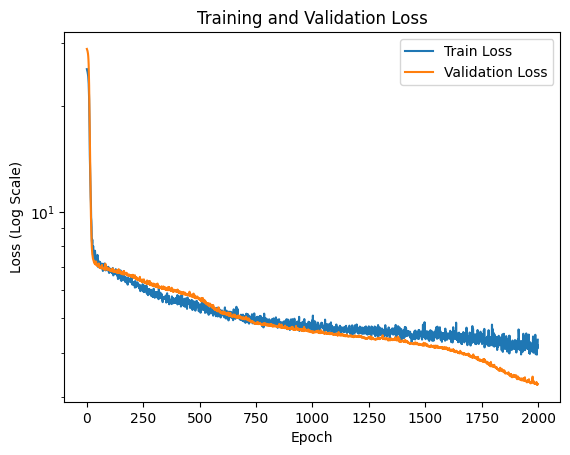

In [6]:
# -----------------------------
# 1. Extract fraud samples using label_train (1 = fraud)
# -----------------------------
# data_train and label_train are assumed to be already defined from your previous splitting.
data_train_fraud = data_train[label_train == 1]

# -----------------------------
# 2. Train/Validation Split (80-20) on the fraud samples
# -----------------------------
data_train_autoencoder, test_data_autoencoder = train_test_split(data_train_fraud, test_size=0.2, random_state=32)

print(data_train_autoencoder.shape)
# Convert numpy arrays to PyTorch tensors (ensure float type)
tensor_fraud_train = torch.from_numpy(data_train_autoencoder).float()
tensor_fraud_val   = torch.from_numpy(test_data_autoencoder).float()

# For an autoencoder, input equals target
train_dataset = TensorDataset(tensor_fraud_train, tensor_fraud_train)
val_dataset   = TensorDataset(tensor_fraud_val, tensor_fraud_val)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

# -----------------------------
# 4. Initialize Model, Loss, Optimizer, and Scheduler
# -----------------------------
my_autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()  # Using MSELoss now
optimizer = optim.Adam(my_autoencoder.parameters(), lr=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=500, eta_min=1e-6)

# -----------------------------
# 5. Training Loop with L1 Regularization and Validation Evaluation
# -----------------------------
num_epochs = 2000
history_loss_train = []
history_loss_val   = []
patience = 75
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

l1_lambda = 5e-3  # L1 regularization strength

for epoch in range(num_epochs):
    my_autoencoder.train()
    running_loss_train = 0.0
    for batch_x, _ in train_loader:
        inputs = batch_x.to(device)
        optimizer.zero_grad()
        outputs = my_autoencoder(inputs)
        loss = criterion(outputs, inputs)
        
        # Compute L1 norm of the model parameters
        l1_norm = sum(p.abs().sum() for p in my_autoencoder.parameters())
        loss = loss + l1_lambda * l1_norm
        
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item() * inputs.size(0)
    
    epoch_loss_train = running_loss_train / len(train_loader.dataset)
    history_loss_train.append(epoch_loss_train)

    # --- Validation Phase ---
    my_autoencoder.eval()
    running_loss_val = 0.0
    with torch.no_grad():
        for batch_x, _ in val_loader:
            inputs = batch_x.to(device)
            outputs = my_autoencoder(inputs)
            loss = criterion(outputs, inputs)
            running_loss_val += loss.item() * inputs.size(0)
    epoch_loss_val = running_loss_val / len(val_loader.dataset)
    history_loss_val.append(epoch_loss_val)

    # Early stopping check
    if epoch_loss_val < best_val_loss:
        best_val_loss = epoch_loss_val
        best_model_state = my_autoencoder.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        my_autoencoder.load_state_dict(best_model_state)
        break

    # Optionally step the scheduler
    # scheduler.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Train Loss: {epoch_loss_train:.4f}, Val Loss: {epoch_loss_val:.4f}")

# Save the model
torch.save(my_autoencoder.state_dict(), "autoencoder.pth")

# -----------------------------
# 6. Plot Training & Validation Loss
# -----------------------------
plt.figure()
plt.plot(history_loss_train, label='Train Loss')
plt.plot(history_loss_val, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss (Log Scale)")
plt.title("Training and Validation Loss")
plt.yscale('log')
plt.legend()
plt.show()


In [7]:
# create the balanced dataset to train the SVM model
data_train_non_fraud = data_train[label_train == 0][:len(data_train_fraud)]

# Combine the selected data
X_balanced_SVM = np.vstack((data_train_non_fraud, data_train_fraud))
y_balanced_SVM = np.hstack((np.zeros(len(data_train_fraud)), np.ones(len(data_train_fraud))))  # Create labels: 0 for non-fraud, 1 for fraud

# Shuffle the data
shuffle_idx = np.random.permutation(len(X_balanced_SVM))
X_balanced_SVM = X_balanced_SVM[shuffle_idx]
y_balanced_SVM = y_balanced_SVM[shuffle_idx]

# Split into training and test sets for SVM
data_train_SVM, data_test_SVM, label_train_SVM, label_test_SVM = train_test_split(X_balanced_SVM, y_balanced_SVM, test_size=0.2, random_state=42)

# Train SVM model for validation in the oversampling process
my_svm = SVC(kernel='linear', C=1.0)
my_svm.fit(data_train_SVM, label_train_SVM)

# Get predictions and accuracy
label_pred_test = my_svm.predict(data_test_SVM)
label_pred_train = my_svm.predict(data_train_SVM)
accuracy_train = np.mean(label_pred_train == label_train_SVM)
accuracy_test = np.mean(label_pred_test == label_test_SVM)

print(f"Train Accuracy: {accuracy_train:.4f}")
print(f"Test Accuracy: {accuracy_test:.4f}")

Train Accuracy: 0.9490
Test Accuracy: 0.9301


In [8]:
# Create an oversampled dataset starting with the original training data
oversampled_data = data_train.copy()    # features only
oversampled_labels = label_train.copy()   # corresponding labels

# For oversampling, we want to add synthetic fraud samples until fraud count equals non-fraud count.
non_fraud_count = np.sum(oversampled_labels == 0)
fraud_count = np.sum(oversampled_labels == 1)
print(f"Initial counts - Fraud: {fraud_count}, Non-fraud: {non_fraud_count}")

# Number of synthetic samples to generate per iteration and noise std
n_samples_per_iter = 300

# Use only the original fraud samples (from the training set) as the basis for synthetic data generation.
original_fraud_data = data_train[label_train == 1]

# Ensure the autoencoder is in evaluation mode
my_autoencoder.eval()

# Continue generating synthetic fraud samples until the oversampled dataset is balanced
while fraud_count < non_fraud_count:
    # 1) Encode the original fraud data to the latent space
    fraud_tensor = torch.tensor(original_fraud_data, dtype=torch.float32).to(device)
    latent_reps = my_autoencoder.encoder(fraud_tensor).detach()
    n_fraud_samples = latent_reps.shape[0]
    
    synthetic_latents = []
    # 2) Generate new latent vectors by interpolating between two random latent vectors and adding noise
    for _ in range(n_samples_per_iter):
        i, j = np.random.choice(n_fraud_samples, size=2, replace=True)
        z_i = latent_reps[i]
        z_j = latent_reps[j]
        lam = np.random.rand()
        z_interp = lam * z_i + (1 - lam) * z_j
        
        # Add Gaussian noise to the interpolated latent vector
        noise = torch.normal(mean=0.0, std=0.5, size=z_interp.shape).to(device)
        z_syn = z_interp + noise
        synthetic_latents.append(z_syn.cpu().numpy())
    
    synthetic_latents = np.array(synthetic_latents)
    synthetic_latents_tensor = torch.tensor(synthetic_latents, dtype=torch.float32).to(device)
    
    # 3) Decode the synthetic latent vectors to the original feature space
    synthetic_data = my_autoencoder.decoder(synthetic_latents_tensor).detach().cpu().numpy()
    
    # 4) Evaluate the synthetic samples using the trained SVM.
    #    Keep only those samples that the SVM predicts as fraud (i.e. label 1)
    y_pred = my_svm.predict(synthetic_data)
    synthetic_fraud = synthetic_data[y_pred == 1]
    
    if synthetic_fraud.shape[0] == 0:
        print("No synthetic fraud samples passed SVM check in this iteration. Trying again...")
        continue
    
    # 5) Append the accepted synthetic fraud samples to the oversampled dataset.
    oversampled_data = np.vstack((oversampled_data, synthetic_fraud))
    oversampled_labels = np.hstack((oversampled_labels, np.ones(synthetic_fraud.shape[0])))
    
    # Update counts
    fraud_count = np.sum(oversampled_labels == 1)
    non_fraud_count = np.sum(oversampled_labels == 0)
    print(f"Added {synthetic_fraud.shape[0]} synthetic fraud samples. Now, Fraud: {fraud_count}, Non-fraud: {non_fraud_count}")

print("Balanced oversampled dataset achieved.")
print(f"Final dataset shape: {oversampled_data.shape}")

Initial counts - Fraud: 356, Non-fraud: 199008
Added 300 synthetic fraud samples. Now, Fraud: 656, Non-fraud: 199008
Added 300 synthetic fraud samples. Now, Fraud: 956, Non-fraud: 199008
Added 300 synthetic fraud samples. Now, Fraud: 1256, Non-fraud: 199008
Added 300 synthetic fraud samples. Now, Fraud: 1556, Non-fraud: 199008
Added 300 synthetic fraud samples. Now, Fraud: 1856, Non-fraud: 199008
Added 300 synthetic fraud samples. Now, Fraud: 2156, Non-fraud: 199008
Added 300 synthetic fraud samples. Now, Fraud: 2456, Non-fraud: 199008
Added 300 synthetic fraud samples. Now, Fraud: 2756, Non-fraud: 199008
Added 300 synthetic fraud samples. Now, Fraud: 3056, Non-fraud: 199008
Added 300 synthetic fraud samples. Now, Fraud: 3356, Non-fraud: 199008
Added 300 synthetic fraud samples. Now, Fraud: 3656, Non-fraud: 199008
Added 300 synthetic fraud samples. Now, Fraud: 3956, Non-fraud: 199008
Added 300 synthetic fraud samples. Now, Fraud: 4256, Non-fraud: 199008
Added 300 synthetic fraud sample

In [9]:
from imblearn.over_sampling import BorderlineSMOTE, KMeansSMOTE

borderlineSMOTE = BorderlineSMOTE(random_state=42)

X_train_with_smote, y_train_with_smote = borderlineSMOTE.fit_resample(data_train, label_train)

print(X_train_with_smote.shape)

(398016, 29)


In [10]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Dropout,Input, Attention, Layer, Concatenate, Permute, Dot, Multiply, Flatten
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.models import Model

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=tf.squeeze(tf.tanh(tf.linalg.matmul(x,self.W)+self.b),axis=-1)
        at=tf.nn.softmax(et)
        at=tf.expand_dims(at,axis=-1)
        output=x*at
        return tf.reduce_sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

def create_ALSTM_model():
    inputs1=Input((1,29))
    att_in=LSTM(50,return_sequences=True,dropout=0.3,recurrent_dropout=0.2)(inputs1)
    att_in_1=LSTM(50,return_sequences=True,dropout=0.3,recurrent_dropout=0.2)(att_in)
    att_out=attention()(att_in_1)
    outputs1=Dense(1,activation='sigmoid',trainable=True)(att_out)
    model1=Model(inputs1,outputs1)
    
    model1.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

    return model1

In [11]:
from scipy.optimize import minimize_scalar

# --- Adjusted training function using Keras without a validation dataset ---
def train_model(model, X, y, num_epochs=2, batch_size=128):
    # Ensure X has shape (num_samples, 1, 30)
    if X.ndim == 2:
        X_train = X.reshape(-1, 1, X.shape[1])
    else:
        X_train = X

    # Train the model using Keras' fit without validation monitoring
    history = model.fit(X_train, y, epochs=num_epochs, batch_size=batch_size, verbose=1)
    return model

def GB_classifier(X, y, n_estimators=10):
    estimators = []
    
    # Define squared-error loss (for evaluating the ensemble)
    loss_fn = lambda y_true, y_pred: 0.5 * np.sum((y_true - y_pred)**2)
    
    # Initialize ensemble predictions for training data
    hx = np.full(len(y), 0, dtype=np.float32)
    
    for t in range(n_estimators):
        # Compute training residuals: true labels minus current ensemble predictions
        residuals = y - hx
        
        # Create a new instance of the Keras ALSTM model
        model_t = create_ALSTM_model()
        
        # Train the model on (X, residuals)
        train_model(model_t, X, residuals, num_epochs=2, batch_size=128)
        
        # Predict the current weak learner's output h_t on the training set.
        X_input = X.reshape(-1, 1, X.shape[1]) if X.ndim == 2 else X
        predictions = model_t.predict(X_input)
        h_t = predictions.flatten()
        
        # Use line search to determine the optimal step length alpha
        func = lambda alpha: np.sum(loss_fn(y, hx + alpha * h_t))
        alpha_t = np.float32(minimize_scalar(func, method="golden").x)
        
        # Update the ensemble predictions for training data
        hx += alpha_t * h_t
        
        print(f"a_{t+1} = {alpha_t:.4f}")
        print(f"hx_{t+1} = {hx}")
        
        estimators.append((model_t, alpha_t))
    
    return estimators

In [12]:
estimators = GB_classifier(oversampled_data, oversampled_labels, n_estimators=6)
# estimators = GB_classifier(X_train_with_smote, y_train_with_smote, n_estimators=6)

Epoch 1/2
3112/3112 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.9812 - loss: 0.0247
Epoch 2/2
3112/3112 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.9989 - loss: 9.7476e-04
12446/12446 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step
a_1 = 0.9998
hx_1 = [6.0683953e-05 1.8650604e-05 1.2421064e-04 ... 9.9976325e-01 9.9976408e-01
 9.9975955e-01]
Epoch 1/2
3112/3112 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - accuracy: 0.0000e+00 - loss: 0.0191
Epoch 2/2
3112/3112 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.0000e+00 - loss: 3.0605e-04
12446/12446 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step
a_2 = 0.5341
hx_2 = [1.5575645e-04 3.9850034e-05 1.6302802e-04 ... 9.9979609e-01 9.9976772e-01
 9.9976134e-01]
Epoch 1/2
3112/3112 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - accuracy: 0.0000e+00 - loss: 0.0195
Epoch 2/2
3112/3112 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.0000e+00 - loss: 3.3319e-04
12446/12446 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step
a_3 = 0.0498
hx_3 = [1.6191587e-04 4.5057262e-05 1.6606918e-04 ... 9.9980068e-01 9.9

In [13]:
# Assuming data_test and label_test are defined from your earlier train_test_split
# Ensure data_test has shape (n_samples, 1, 30) if needed by the model
if data_test.ndim == 2:
    data_test_input = data_test.reshape(-1, 1, data_test.shape[1])
else:
    data_test_input = data_test

hx = np.full(len(data_test_input), 0, dtype=np.float32)

# Go through each model in the trained ensemble
for model, alpha in estimators:
    prediction = model.predict(data_test_input).flatten()
    hx += alpha * prediction

# Threshold the accumulated predictions to get binary outputs
y_pred_binary = np.where(hx > 0.5, 1, 0)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

precision = precision_score(label_test, y_pred_binary)
recall = recall_score(label_test, y_pred_binary)
f1 = f1_score(label_test, y_pred_binary)
accuracy = accuracy_score(label_test, y_pred_binary)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

2671/2671 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Precision: 0.7887
Recall: 0.8235
F1 Score: 0.8058
Accuracy: 0.9994


Confusion Matrix:
[[85277    30]
 [   24   112]]


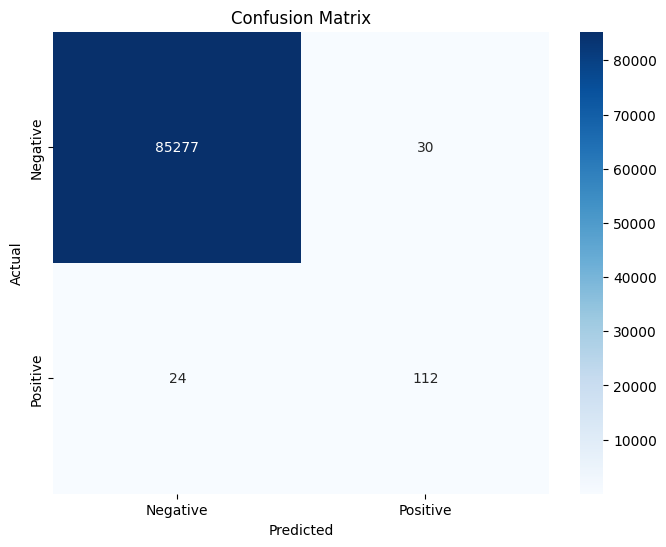

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Add after your existing metrics
cm = confusion_matrix(label_test, y_pred_binary)
print("Confusion Matrix:")
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()